The singature should be of float type ... DONE <br/>
Integrate FGSM ... DONE  <br/>
Visualize three adv samples (at the beginning of this notebook) ... DONE  <br/>
Integrate more attacks ... DONE  <br/>
Generate and store all possible attacks you could generate ... <br/>
Complete the generalization of the same type of adv attacks ...  <br/>
(if fail) -> try DRAW architecture ...  <br/>

In [1]:
import PI

meta_params = {
    'num_of_train_dataset': 500,
    'num_of_test_dataset': 100,
    'is_flatten': False
}

PI = PI.PIInterface(meta_params)

import torch
import torch.nn as nn
import torch.optim as optim
from MNIST_models import *
# model = CNN()
# loss_func, optimizer = nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-3)
# model = PI.train_model(model, loss_func, optimizer, 3)
# PI.set_model(model)
# print('train acc:', PI.eval_model('train'))
# print('test acc:', PI.eval_model('test'))
# print()

model = load_model('store/MNIST_CNN.pt')
PI.set_model(model)
print('train acc:', PI.eval_model('train'))
print('test acc:', PI.eval_model('test'))

train acc: 0.974
test acc: 0.99


//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'MNIST_models.CNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dum

Using TensorFlow backend.


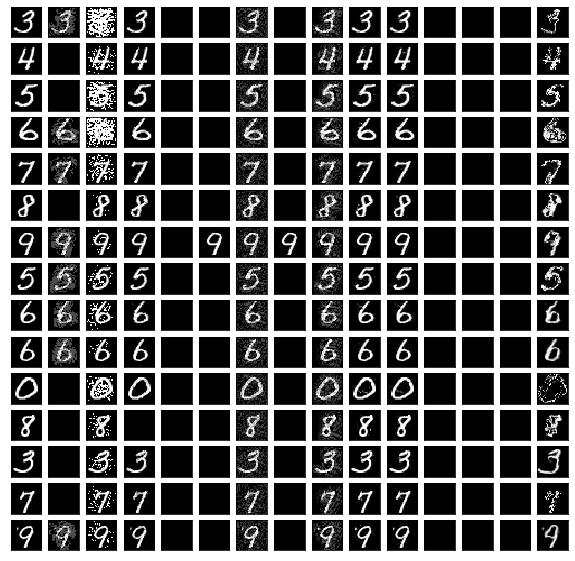

In [2]:
# visualize the benign input and corresponding adv samples 
samples, labels = PI.train_dataset

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import attacker
import time
import warnings
warnings.filterwarnings('ignore')

figsize=(10, 10)
fig=plt.figure(figsize=figsize)
num_of_rows = 15
columns = 15

for i in range(num_of_rows):
    sample, label = samples[i], labels[i]
    for col_index in range(1, columns+1):        
        if col_index == 1: A = None 
        elif col_index == 2: A = attacker.FGSMAttacker()
        elif col_index == 3: A = attacker.JSMAAttacker()
        elif col_index == 4: A = attacker.CWL2Attacker()
        elif col_index == 5: A = attacker.L1PGDAttack()
        elif col_index == 6: A = attacker.L2PGDAttack()
        elif col_index == 7: A = attacker.LinfPGDAttack()    
        elif col_index == 8: A = attacker.L2BasicIterativeAttack()
        elif col_index == 9: A = attacker.LinfBasicIterativeAttack()
        elif col_index == 10: A = attacker.ElasticNetL1Attack()
        elif col_index == 11: A = attacker.DDNL2Attack()
        elif col_index == 12: A = attacker.LBFGSAttack()
        elif col_index == 13: A = attacker.SinglePixelAttack()
        elif col_index == 14: A = attacker.LocalSearchAttack()
        else: A = attacker.SpatialTransformAttack()
            
#         start = time.clock()
        
        if not (A is None):
            adv_sample, is_att_success = A.create_adv_input(sample, label, model)
            if is_att_success: 
                plt_sample = (adv_sample.detach().numpy())[0]
            else:
                plt_sample = np.zeros((1, 28, 28)) 
        else: 
            plt_sample = sample
            
#         end = time.clock()
#         print(i+1, col_index)
#         print('time for adv sample generation',(end-start))

        fig.add_subplot(num_of_rows, columns, col_index+(i*columns))
        plt.imshow(np.squeeze(plt_sample), cmap='gray')
        plt.xticks([])
        plt.yticks([])

fig.savefig('out.png')

In [3]:
import pickle

# STORE
# set_of_signatures = PI.generate_signatures() 
# fn_name = 'store/normal.txt'
# with open(fn_name, "wb") as fp:   
#     pickle.dump(set_of_signatures, fp)
    
# set_of_adv_FGSM_signatures = PI.generate_signatures(is_benign=False, type_of_attack='FGSM') #eps = 0.3 
# fn_name = 'store/FGSM_eps_0.30.txt'
# with open(fn_name, "wb") as fp:  
#     pickle.dump(set_of_adv_FGSM_signatures, fp)
    
# set_of_adv_JSMA_signatures = PI.generate_signatures(is_benign=False, type_of_attack='JSMA')
# fn_name = 'store/JSMA.txt'
# with open(fn_name, "wb") as fp:  
#     pickle.dump(set_of_adv_JSMA_signatures, fp)

# set_of_adv_CWL2_signatures = PI.generate_signatures(is_benign=False, type_of_attack='CWL2')
# fn_name = 'store/CWL2.txt'
# with open(fn_name, "wb") as fp:  
#     pickle.dump(set_of_adv_CWL2_signatures, fp)
    
# # LOAD 
fn_name = 'store/normal.txt'
fp = open(fn_name, 'rb')
set_of_signatures = pickle.load(fp)
fp.close()
    
fn_name = 'store/FGSM_eps_0.30.txt'
fp = open(fn_name, 'rb')
set_of_adv_FGSM_signatures = pickle.load(fp)
fp.close()

fn_name = 'store/JSMA.txt'
fp = open(fn_name, 'rb')
set_of_adv_JSMA_signatures = pickle.load(fp)
fp.close()

fn_name = 'store/CWL2.txt'
fp = open(fn_name, 'rb')
set_of_adv_CWL2_signatures = pickle.load(fp)
fp.close()

In [4]:
split_percentage = 0.8
split_line = int(0.8 * len(set_of_signatures))
train_set_of_signatures, test_set_of_signatures = set_of_signatures[:split_line], set_of_signatures[split_line:]
print(len(train_set_of_signatures), len(test_set_of_signatures), len(set_of_signatures))

split_line = int(0.8 * len(set_of_adv_FGSM_signatures))
train_set_of_adv_FGSM_signatures, test_set_of_adv_FGSM_signatures = set_of_adv_FGSM_signatures[:split_line], set_of_adv_FGSM_signatures[split_line:]
print(len(train_set_of_adv_FGSM_signatures), len(test_set_of_adv_FGSM_signatures), len(set_of_adv_FGSM_signatures))

split_line = int(0.8 * len(set_of_adv_JSMA_signatures))
train_set_of_adv_JSMA_signatures, test_set_of_adv_JSMA_signatures = set_of_adv_JSMA_signatures[:split_line], set_of_adv_JSMA_signatures[split_line:]
print(len(train_set_of_adv_JSMA_signatures), len(test_set_of_adv_JSMA_signatures), len(set_of_adv_JSMA_signatures))

split_line = int(0.8 * len(set_of_adv_CWL2_signatures))
train_set_of_adv_CWL2_signatures, test_set_of_adv_CWL2_signatures = set_of_adv_CWL2_signatures[:split_line], set_of_adv_CWL2_signatures[split_line:]
print(len(train_set_of_adv_CWL2_signatures), len(test_set_of_adv_CWL2_signatures), len(set_of_adv_CWL2_signatures))


400 100 500
212 53 265
389 98 487
200 50 250


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch

guard_model = Guard()
guard_model.train()
epoches = 50
accs, losses = train_guard_model(guard_model, train_set_of_signatures, [], [], train_set_of_adv_CWL2_signatures, epoches)
# accs, losses = train_guard_model(guard_model, train_set_of_signatures, train_set_of_adv_FGSM_signatures, train_set_of_adv_JSMA_signatures, train_set_of_adv_CWL2_signatures, epoches)
losses = [x.item() for x in losses]
guard_model.eval()
torch.save(guard_model, 'store/guard.pt')
# guard_model = torch.load('guard.pt')

epoch: 1 loss: tensor(147.0782, grad_fn=<AddBackward0>)
benign correct: 396 / 400
adv (FGSM) correct: 0 / 0
adv (JSMA) correct: 0 / 0
adv (CWL2) correct: 178 / 200
acc: 0.9566666666666667
epoch: 2 loss: tensor(171.8925, grad_fn=<AddBackward0>)
benign correct: 348 / 400
adv (FGSM) correct: 0 / 0
adv (JSMA) correct: 0 / 0
adv (CWL2) correct: 124 / 200
acc: 0.7866666666666666
epoch: 3 loss: tensor(154.6952, grad_fn=<AddBackward0>)
benign correct: 334 / 400
adv (FGSM) correct: 0 / 0
adv (JSMA) correct: 0 / 0
adv (CWL2) correct: 126 / 200
acc: 0.7666666666666667
epoch: 4 loss: tensor(172.3225, grad_fn=<AddBackward0>)
benign correct: 330 / 400
adv (FGSM) correct: 0 / 0
adv (JSMA) correct: 0 / 0
adv (CWL2) correct: 109 / 200
acc: 0.7316666666666667
epoch: 5 loss: tensor(151.1873, grad_fn=<AddBackward0>)
benign correct: 366 / 400
adv (FGSM) correct: 0 / 0
adv (JSMA) correct: 0 / 0
adv (CWL2) correct: 115 / 200
acc: 0.8016666666666666
epoch: 6 loss: tensor(130.0144, grad_fn=<AddBackward0>)
beni

In [ ]:
import copy
from scipy.ndimage.filters import gaussian_filter1d
smooth_accs = gaussian_filter1d(accs, sigma=2)
smooth_losses = gaussian_filter1d(losses, sigma=2)
norm_smooth_losses = [float(i)/max(smooth_losses) for i in smooth_losses]

from matplotlib import pyplot as plt
# declare a figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

# summarize history for accuracy
plt.plot(smooth_accs)
plt.plot(norm_smooth_losses)
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'loss'], loc='upper left')
plt.show()

In [ ]:
test_guard_model(guard_model, test_set_of_signatures, test_set_of_adv_FGSM_signatures, test_set_of_adv_JSMA_signatures, test_set_of_adv_CWL2_signatures)